In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyIEEM.models.utils import initialize_model

In [3]:
def max_utility_function(I_star, alpha, beta, gamma, delta, psi, m, RL, l0):
    max_work_actual = (((1-alpha)*m*l0*(1-RL)*(1-psi))/(alpha*beta*I_star**beta))**(1/(beta-1))
    max_work_effective = (((1-alpha)*m*l0*(1-RL)*psi)/(alpha*beta*I_star**delta))**(1/(delta-1))
    l_i = l0*(RL + (1-RL)*((1-psi)*max_work_actual + psi*max_work_effective))
    max_leisure =(((1-alpha)*m*l_i*0.2)/(alpha*gamma*I_star**gamma))**(1/(gamma-1))
    return min(max_work_actual,1), min(max_work_effective,1), min(max_leisure, 1)

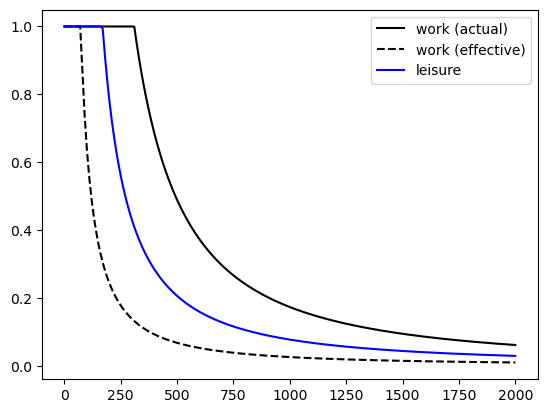

In [4]:
I_star = np.linspace(1,2000,201)

RL = 0.90
alpha = 1e-9
beta = 3
gamma = 3.5
delta = 3.5
psi = 0.1
l0 = 1
m = 1

work_actual = []
work_effective = []
leisure = []
for I in I_star:
    w_act, w_eff, l = max_utility_function(I, alpha, beta, gamma, delta, psi, m, RL, l0)
    work_actual.append(w_act)
    work_effective.append(w_eff)
    leisure.append(l)

fig,ax=plt.subplots()
ax.plot(I_star, work_actual, color='black', label='work (actual)')
ax.plot(I_star, work_effective, color='black', linestyle='--', label='work (effective)')
ax.plot(I_star, leisure, color='blue', label='leisure')
#ax.plot(I_star, leisure_actual, color='blue', linestyle='--', label='leisure')
ax.legend()
plt.show()
plt.close()

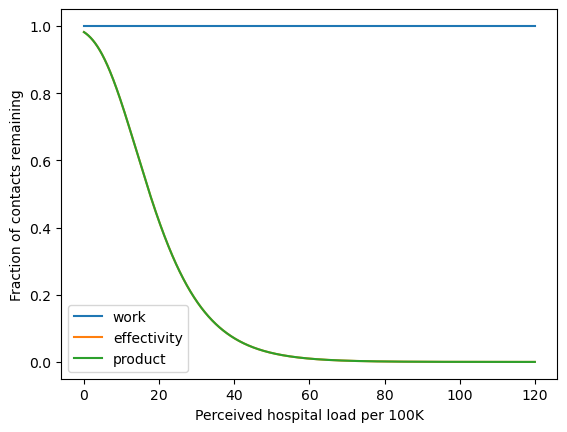

In [65]:
# parameters
ypsilon_work = 100
phi_work = 0.005

ypsilon_eff = 4
phi_eff = 0.10
# model
x = np.linspace(0,120,1000)
y_work = (1-np.exp(-ypsilon_work*np.exp(-phi_work*x)))
y_eff = 1-np.exp(-ypsilon_eff*np.exp(-phi_eff*x))

# visualize
fig,ax=plt.subplots()
ax.plot(x, y_work, label='work')
ax.plot(x, y_eff, label='effectivity')
ax.plot(x, y_work*y_eff, label='product')
ax.set_xlabel('Perceived hospital load per 100K')
ax.set_ylabel('Fraction of contacts remaining')
ax.legend()
plt.show()
plt.close()

In [104]:
country = 'BE'
spatial = True
age_classes = pd.IntervalIndex.from_tuples([(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,120)], closed='left')
simulation_start = '2020-02-21'
model = initialize_model(country, age_classes, spatial, simulation_start, contact_type='absolute_contacts')

2020-02-21 00:00:00 0.021798663341875964 re-init
2020-02-21 00:57:59.134575 0.02199543672209635 re-init
2020-02-21 00:26:00.927602 0.021886946503618335 re-init
2020-02-21 00:39:01.391402 0.021931661491314234 re-init
2020-02-21 00:52:01.855203 0.02197599649078726 re-init
2020-02-21 05:12:11.131219 0.0228665077204631 re-init
2020-02-21 07:22:15.769228 0.023369616475169563 re-init
2020-02-21 09:32:20.407236 0.02383642899565661 re-init
2020-02-22 00:43:53.215830 0.02723871908109448 re-init
2020-02-22 08:19:39.620128 0.0297125370275957 re-init
2020-02-22 15:55:26.024425 0.03176855038143863 re-init
2020-02-23 07:51:33.837673 0.03657614872137972 re-init
2020-02-23 15:49:37.744297 0.04010963161395474 re-init
2020-02-23 23:47:41.650921 0.043029312079468085 re-init
2020-02-24 15:58:01.736719 0.049682601420892945 re-init
2020-02-25 00:03:11.779618 0.05457004682226931 re-init
2020-02-25 08:08:21.822518 0.05863508462174956 re-init
2020-02-24 06:18:53.845475 0.04571167331776049 re-init
2020-02-24 09

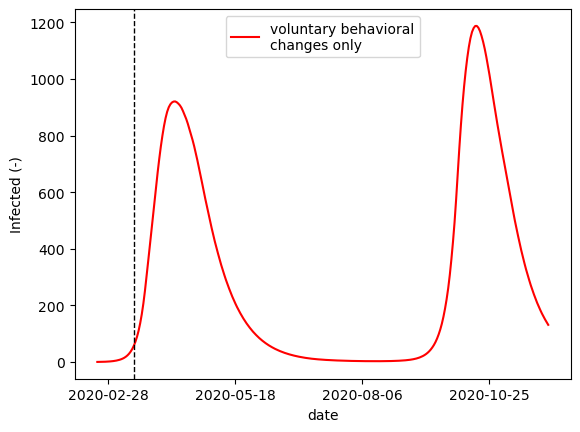

In [106]:
fig,ax = plt.subplots()

model.parameters['tau'] = 45
model.parameters['ypsilon_eff'] = 3
model.parameters['phi_eff'] = 0.15

# economic lockdown, schools closed, preventive measures, social restrictions
#model.parameters['economic_closures'].loc[slice(None)] = 1
#out = model.sim([simulation_start, '2020-12-01'])
#ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')

# economic lockdown, schools open, preventive measures, social restrictions
#model.parameters['economic_closures'].loc['P85'] = 0
#out = model.sim([simulation_start, '2020-12-01'])
#ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), 'orange', label='lockdown (schools open)')

# do-nothing
model.parameters['social_restrictions'] = 0
model.parameters['economic_closures'].loc[slice(None)] = 0
out = model.sim([simulation_start, '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='red', label='voluntary behavioral\nchanges only')

ax.legend()
ax.axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax.set_xlabel('date')
ax.set_ylabel('Infected (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))

#plt.savefig(f'scenarios_{country}.png', dpi=600)
plt.show()
plt.close()

In [118]:
def compute_beta(R0, delta, gamma, s, N, demography):
    beta_i = R0/(s*(delta+gamma)*np.expand_dims(np.sum(N, axis=0),axis=1))
    return sum(np.squeeze(beta_i)*demography/sum(demography))

In [121]:
N = np.squeeze(model.parameters['N']['other'] + model.parameters['G']*model.parameters['N']['work'])
demography = pd.read_csv(f'../data/interim/epi/demographic/age_structure_{country}_2019.csv', index_col=[0, 1]).groupby(by='age').sum().squeeze()
demography = demography.groupby(pd.cut(demography.index.values, age_classes)).sum()
compute_beta(2.75, model.parameters['delta'], model.parameters['gamma'], model.parameters['s'], N, demography.values)

0.02733129308543969